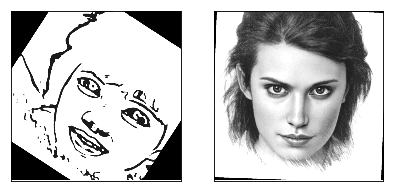

In [2]:
# 解压数据集，首次运行后注释
# !unzip -qa -d /home/aistudio/data/data218261/ /home/aistudio/data/data218261/selfie2anime_textlist.zip


import paddle.fluid as fluid
import data_reader_epoch as data_reader
import paddle
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import cv2


def show_pics(pics, heatmap=np.zeros((1, 1))):
    plt.figure(figsize=(3 * len(pics), 3), dpi=80)
    for i in range(len(pics)):
        # pics[i] = np.array([pics[i] for _ in range(3)])
        pics[i] = (pics[i][0].transpose((1,2,0)) + 1) / 2
        # print(pics[i].shape)
        plt.subplot(1, len(pics), i + 1)
        # plt.imshow(pics[i][0], cmap='gray')
        pics[i] = cv2.cvtColor(pics[i], cv2.COLOR_RGB2GRAY)
        pics[i] = cv2.bilateralFilter(pics[i], 3, 60, 10)

        plt.imshow(pics[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])


def open_pic(file_name='./data/data218261/testA/1.jpg'):
    img = Image.open(file_name).resize((1024, 1024), Image.BILINEAR)
    img = (np.array(img).astype('float32') / 255.0 - 0.5) / 0.5
    img = img.transpose((2, 0, 1))
    img = img.reshape((-1, img.shape[0], img.shape[1], img.shape[2]))
    return img

class CFG:
    def __init__(self):
        self.batch_size = 1
        self.image_size = 1024
        self.crop_size = 1024
        self.crop_type = 'Random'
        self.use_gpu = True
        self.shuffle = True
        self.dataset = '/home/aistudio/data/data218261/'
        self.model_net = 'CycleGAN'
        self.data_dir = './data'
        self.run_test = True

cfg = CFG()

reader = data_reader.data_reader(cfg)
A_reader, B_reader, a_reader_test, b_reader_test, batch_num, a_id2name, b_id2name = reader.make_data()

data_a = next(A_reader())
data_b = next(B_reader())

data_a = data_a[0]
data_b = data_b[0]

show_pics([data_a, data_b])

In [3]:
from PIL import Image
def save_pics(pics, file_name='tmp', save_path='./output/pics/'):
    for i in range(len(pics)):
        pics[i] = pics[i][0]
    pic = np.concatenate(tuple(pics), axis=2)
    pic = pic.transpose((1,2,0))
    pic = (pic + 1) / 2
    pic = np.clip(pic * 256, 0, 255)
    img = Image.fromarray(pic.astype('uint8')).convert('RGB')
    img.save(save_path+file_name+'.jpg')
    
# save_pics([data_a, data_b])

In [4]:
import paddle.fluid as fluid
from paddle.fluid.dygraph import Conv2D, Linear, Dropout, BatchNorm, Pool2D, Conv2DTranspose, InstanceNorm, SpectralNorm
import numpy as np

class Disc(fluid.dygraph.Layer):
    def __init__(self):
        super(Disc, self).__init__()
        
        # self.conv1 = Conv2D(6, 64, 4, stride=2, padding=1, bias_attr=True, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.conv1 = Conv2D(3, 64, 4, stride=2, padding=1, bias_attr=True, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.in1 = InstanceNorm(64)
        self.conv2 = Conv2D(64, 128, 4, stride=2, padding=1, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.in2 = InstanceNorm(128)
        self.conv3 = Conv2D(128, 256, 4, stride=2, padding=1, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.in3 = InstanceNorm(256)
        self.conv4 = Conv2D(256, 512, 4, padding=1, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.in4 = InstanceNorm(512)
        self.conv5 = Conv2D(512, 1, 4, padding=1, bias_attr=True, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))

    def forward(self, x):
        x = self.conv1(x)
        x = self.in1(x)
        x = fluid.layers.leaky_relu(x, alpha=0.2)

        x = self.conv2(x)
        x = self.in2(x)
        x = fluid.layers.leaky_relu(x, alpha=0.2)

        x = self.conv3(x)
        x = self.in3(x)
        x = fluid.layers.leaky_relu(x, alpha=0.2)

        x = self.conv4(x)
        x = self.in4(x)
        x = fluid.layers.leaky_relu(x, alpha=0.2)

        x = self.conv5(x)

        return x

# 定义生成器使用的残差块
class Residual(fluid.dygraph.Layer):
    def __init__(self, input_output_dim, use_bias):
        super(Residual, self).__init__()
        name_scope = self.full_name()

        self.conv1 = Conv2D(input_output_dim, input_output_dim, 3, bias_attr=use_bias, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn1 = BatchNorm(input_output_dim)
        self.conv2 = Conv2D(input_output_dim, input_output_dim, 3, bias_attr=use_bias, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn2 = BatchNorm(input_output_dim)

    def forward(self, x_input):
        x = fluid.layers.pad2d(x_input, [1, 1, 1, 1], mode='reflect')
        x = self.conv1(x)
        x = self.bn1(x)
        x = fluid.layers.relu(x)

        x = fluid.layers.pad2d(x, [1, 1, 1, 1], mode='reflect')
        x = self.conv2(x)
        x = self.bn2(x)
        
        return x + x_input

# 定义ResNet版的生成器
class Gen(fluid.dygraph.Layer):
    def __init__(self, base_dim=64, residual_num=8):
        super(Gen, self).__init__()

        self.residual_num = residual_num

        self.conv1 = Conv2D(3, base_dim, 7, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn1 = BatchNorm(base_dim)
        self.conv2 = Conv2D(base_dim, base_dim * 2, 3, padding=1, stride=2, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn2 = BatchNorm(base_dim * 2)
        self.conv3 = Conv2D(base_dim * 2, base_dim * 4, 3, padding=1, stride=2, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn3 = BatchNorm(base_dim * 4)

        self.residual_list = []
        for i in range(residual_num):
            layer = self.add_sublayer('res_'+str(i), Residual(base_dim * 4, False))
            self.residual_list.append(layer)

        self.convTrans1 = Conv2DTranspose(base_dim * 4, base_dim * 2, 3, stride=2, padding=1, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn4 = BatchNorm(base_dim * 2)
        self.convTrans2 = Conv2DTranspose(base_dim * 2, base_dim, 3, stride=2, padding=1, bias_attr=False, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))
        self.bn5 = BatchNorm(base_dim)
        self.conv4 = Conv2D(base_dim, 3, 7, bias_attr=True, param_attr=fluid.initializer.NormalInitializer(loc=0, scale=0.02))

    def forward(self, x):
        x = fluid.layers.pad2d(x, [3, 3, 3, 3], mode='reflect')
        x = self.conv1(x)
        x = self.bn1(x)
        x = fluid.layers.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = fluid.layers.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = fluid.layers.relu(x)

        for res_layer in self.residual_list:
            x = res_layer(x)

        x = self.convTrans1(x)
        x = self.bn4(x)
        x = fluid.layers.relu(x)
        x = fluid.layers.pad2d(x, [0, 1, 0, 1], mode='constant', pad_value=0.0)

        x = self.convTrans2(x)
        x = self.bn5(x)
        x = fluid.layers.relu(x)
        x = fluid.layers.pad2d(x, [0, 1, 0, 1], mode='constant', pad_value=0.0)

        x = fluid.layers.pad2d(x, [3, 3, 3, 3], mode='reflect')
        x = self.conv4(x)
        x = fluid.layers.tanh(x)

        return x

In [ ]:
import paddle.fluid as fluid
import time
from PIL import Image, ImageEnhance

class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool = []
        self.count = 0
        self.pool_size = pool_size

    def pool_image(self, image):
        image = image.numpy()
        rtn = ''
        if self.count < self.pool_size:
            self.pool.append(image)
            self.count += 1
            rtn = image
        else:
            p = np.random.rand()
            if p > 0.5:
                random_id = np.random.randint(0, self.pool_size - 1)
                temp = self.pool[random_id]
                self.pool[random_id] = image
                rtn = temp
            else:
                rtn = image
        return fluid.dygraph.to_variable(rtn)

def train(epoch_num=99999, adv_weight=5, cycle_weight=80, identity_weight=60, 
          use_gpu=True, load_model=False, model_path='./model/', model_path_bkp='./model_bkp/', 
          print_interval=1, max_step=50, model_bkp_interval=5000):
    place = fluid.CUDAPlace(0) if use_gpu == True else fluid.CPUPlace()
    with fluid.dygraph.guard(place):
        # model
        g_a = Gen()
        g_b = Gen()
        d_a = Disc()
        d_b = Disc()

        # data
        reader_a, reader_b, _, _, _, _, _ = reader.make_data()

        # optimizer
        g_a_optimizer = fluid.optimizer.Adam(learning_rate=0.0001, beta1=0.5, beta2=0.999, parameter_list=g_a.parameters())
        g_b_optimizer = fluid.optimizer.Adam(learning_rate=0.0001, beta1=0.5, beta2=0.999, parameter_list=g_b.parameters())
        d_a_optimizer = fluid.optimizer.Adam(learning_rate=0.0001, beta1=0.5, beta2=0.999, parameter_list=d_a.parameters())
        d_b_optimizer = fluid.optimizer.Adam(learning_rate=0.0001, beta1=0.5, beta2=0.999, parameter_list=d_b.parameters())

        # image pool
        fa_pool, fb_pool = ImagePool(), ImagePool()

        total_step_num = np.array([0])

        if load_model == True:
            ga_para, ga_opt = fluid.load_dygraph(model_path+'gen_b2a')
            gb_para, gb_opt = fluid.load_dygraph(model_path+'gen_a2b')
            da_para, da_opt = fluid.load_dygraph(model_path+'dis_ga')
            db_para, db_opt = fluid.load_dygraph(model_path+'dis_gb')
            g_a.load_dict(ga_para)
            g_a_optimizer.set_dict(ga_opt)
            g_b.load_dict(gb_para)
            g_b_optimizer.set_dict(gb_opt)
            d_a.load_dict(da_para)
            d_a_optimizer.set_dict(da_opt)
            d_b.load_dict(db_para)
            d_b_optimizer.set_dict(db_opt)
            
            total_step_num = np.load('./model/total_step_num.npy')

        step = total_step_num[0]
        print('Start time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'start step:', step + 1)
        for epoch in range(epoch_num):
            for data_a, data_b in zip(reader_a(), reader_b()):
                step += 1

                # data
                data_a, data_b = np.array(data_a[0]), np.array(data_b[0])
                # data_a[0] = prepare_a(data_a[0]) # A augment
                img_ra = fluid.dygraph.to_variable(data_a)
                img_rb = fluid.dygraph.to_variable(data_b)

                # train DA
                d_loss_ra = fluid.layers.reduce_mean((d_a(img_ra.detach()) - 1) ** 2)
                d_loss_fa = fluid.layers.reduce_mean(d_a(fa_pool.pool_image(g_a(img_rb.detach()))) ** 2)
                da_loss = (d_loss_ra + d_loss_fa) * 0.5
                da_loss.backward()
                d_a_optimizer.minimize(da_loss)
                d_a.clear_gradients()

                # train DB
                d_loss_rb = fluid.layers.reduce_mean((d_b(img_rb.detach()) - 1) ** 2)
                d_loss_fb = fluid.layers.reduce_mean(d_b(fb_pool.pool_image(g_b(img_ra.detach()))) ** 2)
                db_loss = (d_loss_rb + d_loss_fb) * 0.5
                db_loss.backward()
                d_b_optimizer.minimize(db_loss)
                d_b.clear_gradients()

                # train GA
                ga_gan_loss = fluid.layers.reduce_mean((d_a(g_a(img_rb.detach())) - 1) ** 2)
                ga_cyc_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_rb.detach() - g_b(g_a(img_rb.detach()))))
                ga_ide_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_ra.detach() - g_a(img_ra.detach())))
                ga_loss = ga_gan_loss * adv_weight + ga_cyc_loss * cycle_weight + ga_ide_loss * identity_weight
                # ga_loss = ga_gan_loss
                ga_loss.backward()
                g_a_optimizer.minimize(ga_loss)
                g_a.clear_gradients()

                # train GB
                gb_gan_loss = fluid.layers.reduce_mean((d_b(g_b(img_ra.detach())) - 1) ** 2)
                gb_cyc_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_ra.detach() - g_a(g_b(img_ra.detach()))))
                gb_ide_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_rb.detach() - g_b(img_rb.detach())))
                gb_loss = gb_gan_loss * adv_weight + gb_cyc_loss * cycle_weight + gb_ide_loss * identity_weight
                # gb_loss = gb_gan_loss
                gb_loss.backward()
                g_b_optimizer.minimize(gb_loss)
                g_b.clear_gradients()
                
                # save pictures
                if step in range(1, 101):
                    pic_save_interval = 1
                elif step in range(101, 1001):
                    pic_save_interval = 10
                elif step in range(1001, 10001):
                    pic_save_interval = 100
                else:
                    pic_save_interval = 500
                if step % pic_save_interval == 0:
                    save_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy(), \
                               img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()], \
                               str(step))
                    test_pic = open_pic()
                    test_pic_pp = fluid.dygraph.to_variable(test_pic)
                    save_pics([test_pic, g_b(test_pic_pp).numpy()], str(step), save_path='./output/pics_test/')
                
                # print losses & pictures
                if step % print_interval == 0:
                    print([step], \
                          'DA:', da_loss.numpy(), \
                          'DB:', db_loss.numpy(), \
                          'GA:', ga_loss.numpy(), \
                          'GB:', gb_loss.numpy(), \
                          time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                    show_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy()])
                    show_pics([img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()])

                # save models regularly
                if step % model_bkp_interval == 0:
                    fluid.save_dygraph(g_a.state_dict(), model_path_bkp+'gen_b2a')
                    fluid.save_dygraph(g_a_optimizer.state_dict(), model_path_bkp+'gen_b2a')
                    fluid.save_dygraph(g_b.state_dict(), model_path_bkp+'gen_a2b')
                    fluid.save_dygraph(g_b_optimizer.state_dict(), model_path_bkp+'gen_a2b')
                    fluid.save_dygraph(d_a.state_dict(), model_path_bkp+'dis_ga')
                    fluid.save_dygraph(d_a_optimizer.state_dict(), model_path_bkp+'dis_ga')
                    fluid.save_dygraph(d_b.state_dict(), model_path_bkp+'dis_gb')
                    fluid.save_dygraph(d_b_optimizer.state_dict(), model_path_bkp+'dis_gb')
                    np.save(model_path_bkp+'total_step_num', np.array([step]))

                # end train
                if step >= max_step + total_step_num[0]:
                    fluid.save_dygraph(g_a.state_dict(), model_path+'gen_b2a')
                    fluid.save_dygraph(g_a_optimizer.state_dict(), model_path+'gen_b2a')
                    fluid.save_dygraph(g_b.state_dict(), model_path+'gen_a2b')
                    fluid.save_dygraph(g_b_optimizer.state_dict(), model_path+'gen_a2b')
                    fluid.save_dygraph(d_a.state_dict(), model_path+'dis_ga')
                    fluid.save_dygraph(d_a_optimizer.state_dict(), model_path+'dis_ga')
                    fluid.save_dygraph(d_b.state_dict(), model_path+'dis_gb')
                    fluid.save_dygraph(d_b_optimizer.state_dict(), model_path+'dis_gb')
                    np.save(model_path+'total_step_num', np.array([step]))
                    print('End time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'End Step:', step)
                    return

# 重新训练
# train(print_interval=500, max_step=6000, model_bkp_interval = 2000)

# 继续训练
train(load_model=True, print_interval=100, max_step=500, model_bkp_interval = 2000)

Start time : 2023-05-21 18:30:53 start step: 6001


In [8]:
import paddle.fluid as fluid
import os
import cv2

def infer(max_step=10, use_gpu=True, load_model=True, model_path='./model/'):
    place = fluid.CUDAPlace(0) if use_gpu == True else fluid.CPUPlace()
    with fluid.dygraph.guard(place):
        # model
        g_b = Gen()

        # data
        reader_a, reader_b, a_reader_test, _, _, _, _ = reader.make_data()

        if load_model == True:
            gb_para, gb_opt = fluid.load_dygraph(model_path+'gen_a2b')
            g_b.load_dict(gb_para)
        step = 0
        for data_a in a_reader_test():
            step += 1
            data_a = np.array(data_a[0])
            img_ra = fluid.dygraph.to_variable(data_a)
            img_b = g_b(img_ra).numpy() * .9
            save_pics(img_b, f'{step}', './result/')
            #show_pics([data_a, img_b])
            print('(', step, '/', max_step, ')')
            if step >= max_step:
                return

infer(max_step=180)

( 1 / 180 )
( 2 / 180 )
( 3 / 180 )
( 4 / 180 )
( 5 / 180 )
( 6 / 180 )
( 7 / 180 )
( 8 / 180 )
( 9 / 180 )
( 10 / 180 )
( 11 / 180 )
( 12 / 180 )
( 13 / 180 )
( 14 / 180 )
( 15 / 180 )
( 16 / 180 )
( 17 / 180 )
( 18 / 180 )
( 19 / 180 )
( 20 / 180 )
( 21 / 180 )
( 22 / 180 )
( 23 / 180 )
( 24 / 180 )
( 25 / 180 )
( 26 / 180 )
( 27 / 180 )
( 28 / 180 )
( 29 / 180 )
( 30 / 180 )
( 31 / 180 )
( 32 / 180 )
( 33 / 180 )
( 34 / 180 )
( 35 / 180 )
( 36 / 180 )
( 37 / 180 )
( 38 / 180 )
( 39 / 180 )
( 40 / 180 )
( 41 / 180 )
( 42 / 180 )
( 43 / 180 )
( 44 / 180 )
( 45 / 180 )
( 46 / 180 )
( 47 / 180 )
( 48 / 180 )
( 49 / 180 )
( 50 / 180 )
( 51 / 180 )
( 52 / 180 )
( 53 / 180 )
( 54 / 180 )
( 55 / 180 )
( 56 / 180 )
( 57 / 180 )
( 58 / 180 )
( 59 / 180 )
( 60 / 180 )
( 61 / 180 )
( 62 / 180 )
( 63 / 180 )
( 64 / 180 )
( 65 / 180 )
( 66 / 180 )
( 67 / 180 )
( 68 / 180 )
( 69 / 180 )
( 70 / 180 )
( 71 / 180 )
( 72 / 180 )
( 73 / 180 )
( 74 / 180 )
( 75 / 180 )
( 76 / 180 )
( 77 / 180 )
( 78 / 1